In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import scipy
import pandas as pd
import seaborn as sns
from scipy.stats import norm, bernoulli
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os, sys
import matplotlib.patheffects as pe
from plot_utils import make_width_coverage_plot, get_data, transform_features, make_length_table, make_coverage_table, make_error_table
import warnings; warnings.simplefilter('ignore')
from tqdm import tqdm
from baselines import classical_mean_ci
from ppi import ppi_mean_ci
from reppi import ppi_opt_ols_ci_crossfit

In [2]:
np.random.seed(1)

In [3]:
def simulate_LM(n, mu, sigma, num_trails, alpha=0.1):

    length = np.zeros(4)
    coverage = np.zeros(4)
    mse = np.zeros(4)
    index1 = range(int(0.1 * n))
    index2 = range(int(0.1 * n), n)
 
    for i in tqdm(range(num_trails)):
        X = np.ones((n, 1))
        Z = np.random.choice([-1, 0, 1], n)
        Y = np.zeros(n)
        Y[Z == 1] = np.random.randn(np.sum(Z == 1)) * sigma + mu
        Y[Z == -1] = np.random.randn(np.sum(Z == -1)) * sigma - 2
        Y[Z == 0] = np.random.randn(np.sum(Z == 0)) * sigma
        Yhat = Z
        theta_true = (mu - 2) / 3

        X_lab = X[index1]
        X_unlab = X[index2]
        Y_lab = Y[index1]
        Yhat_lab = Yhat[index1]
        Yhat_unlab = Yhat[index2]
        
        # Classical OLS
        l, u = classical_mean_ci(Y_lab, alpha=alpha)
        length[0] += u - l
        coverage[0] += l <= theta_true <= u
        mse[0] += np.abs((u+l)/2 - theta_true)

        # PPI OLS
        l, u = ppi_mean_ci(Y_lab, Yhat_lab, Yhat_unlab, alpha=alpha, lhat=1)
        length[1] += u - l
        coverage[1] += l <= theta_true <= u
        mse[1] += np.abs((u+l)/2 - theta_true)

        # PPI++ OLS
        l, u = ppi_mean_ci(Y_lab, Yhat_lab, Yhat_unlab, alpha=alpha)
        length[2] += u - l
        coverage[2] += l <= theta_true <= u
        mse[2] += np.abs((u+l)/2 - theta_true)
        
        # RePPI OLS Crossfit
        l, u = ppi_opt_ols_ci_crossfit(X_lab, Y_lab, Yhat_lab, X_unlab, Yhat_unlab, alpha=alpha, method='tree')
        length[3] += u[0] - l[0]
        coverage[3] += l[0] <= theta_true <= u[0]
        mse[3] += np.abs((u[0]+l[0])/2 - theta_true)
    length /= num_trails
    coverage /= num_trails
    mse /= num_trails
    return length, coverage, mse


In [4]:
n = 10000
d1 = 5
d2 = 5
num_trails = 100
alpha = 0.1
# plot the length and coverage for different rho
mus = np.linspace(-5, 5, 30)
# mus = np.linspace(-2, 2, 30)
sigma = 1
length_table = np.zeros((len(mus), 4))
coverage_table = np.zeros((len(mus), 4))
mse_table = np.zeros((len(mus), 4))
theory_table = np.zeros((len(mus), 4))
for i, mu in enumerate(tqdm(mus)):
    length_table[i], coverage_table[i], mse_table[i] = simulate_LM(n, mu, sigma, num_trails, alpha=alpha)

100%|██████████| 30/30 [01:15<00:00,  2.52s/it]


In [5]:
print(length_table)

[[0.23794376 0.29345175 0.20535538 0.12550081]
 [0.22380637 0.27748663 0.19714665 0.12264766]
 [0.21061445 0.26277097 0.18878371 0.1202114 ]
 [0.19762908 0.24712267 0.18135214 0.11792559]
 [0.18631102 0.23334534 0.17424362 0.11584979]
 [0.1744855  0.21862889 0.16649713 0.11392473]
 [0.16364215 0.20365209 0.15926894 0.1115397 ]
 [0.15542571 0.19070727 0.15358497 0.11075886]
 [0.14730567 0.17711011 0.14696249 0.10980543]
 [0.14168832 0.16532497 0.14157466 0.10948943]
 [0.13720051 0.15366019 0.13599066 0.10861187]
 [0.13451512 0.14280575 0.13063042 0.10819698]
 [0.13422095 0.13363581 0.1261818  0.10778226]
 [0.13615891 0.12603083 0.1223775  0.10809291]
 [0.14025973 0.12013643 0.11909956 0.10830688]
 [0.14594662 0.11680729 0.11674987 0.10933467]
 [0.15324159 0.11563391 0.11501055 0.11054167]
 [0.16226731 0.11684994 0.11391236 0.11168529]
 [0.17224998 0.12101963 0.11443119 0.11381165]
 [0.18297441 0.12638079 0.11469769 0.1151049 ]
 [0.1950102  0.13429817 0.11642341 0.11740314]
 [0.20783702 

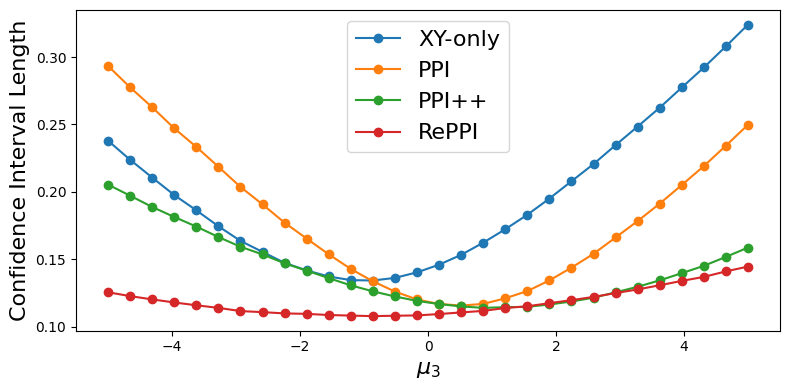

In [6]:
plt.figure(figsize=(8, 4))
plt.plot(mus, length_table[:, 0], label='XY-only', marker='o')
plt.plot(mus, length_table[:, 1], label='PPI', marker='o')
plt.plot(mus, length_table[:, 2], label='PPI++', marker='o')
plt.plot(mus, length_table[:, 3], label='RePPI', marker='o')
# plt.xscale('log')
plt.xlabel(r'$\mu_3$',fontsize=16)
plt.ylabel('Confidence Interval Length',fontsize=16)
plt.legend(prop={'size': 16})
plt.tight_layout()
plt.savefig('../results/length_rho_binary.pdf')

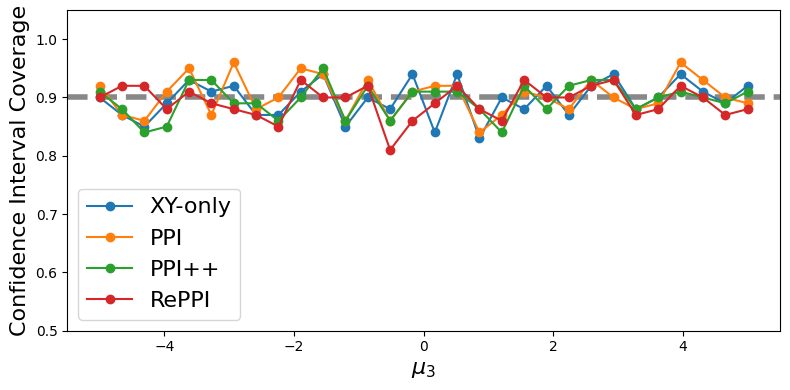

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(mus, coverage_table[:, 0], label='XY-only', marker='o')
plt.plot(mus, coverage_table[:, 1], label='PPI', marker='o')
plt.plot(mus, coverage_table[:, 2], label='PPI++', marker='o')
plt.plot(mus, coverage_table[:, 3], label='RePPI', marker='o')
plt.ylim(0.5,1.05)
plt.xlabel(r'$\mu_3$',fontsize=16)
plt.ylabel('Confidence Interval Coverage',fontsize=16)
plt.axhline(0.9, color="#888888", linestyle='dashed', linewidth=4, zorder=1, alpha=1.0)
plt.legend(prop={'size': 16})
plt.tight_layout()
plt.savefig('../results/coverage_rho_binary.pdf')